In [1]:
#Set working directories
import os

In [2]:
os.getcwd()

'C:\\Users\\midhu\\Documents\\P1'

In [3]:
#os.chdir("..//")
#os.chdir('.\\Image classifier')

In [4]:
os.getcwd()

'C:\\Users\\midhu\\Documents\\P1'

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import time
from random import shuffle
from tqdm import tqdm as tqdm
#import tqdm as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from alpha import create_traindata, random_mini_batch


%matplotlib inline

In [7]:
tf.__version__

'1.4.0'

In [8]:
TRAIN_DIR = ".\\train"
IMG_SIZE = 100
img_shape = (IMG_SIZE,IMG_SIZE,3)

In [9]:
train, label = create_traindata(1200, IMG_SIZE, TRAIN_DIR)

1200it [00:10, 115.35it/s]


1200 Files loaded


In [10]:
label = np.array(label)

In [11]:
train = np.array(train).reshape(-1,IMG_SIZE,IMG_SIZE,3)

In [12]:
label.shape, train.shape

((1200, 1), (1200, 100, 100, 3))

In [13]:
#Shuffle
def shuffle_data(X, Y):
    m = X.shape[0]
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    return shuffled_X, shuffled_Y

In [14]:
train, label = shuffle_data(train, label)

In [15]:
label_df = pd.DataFrame(label, columns = ['classes'])

In [16]:
label_df.head()

,classes
0,dog
1,cat
2,dog
3,cat
4,dog


In [17]:
en = LabelEncoder()
en.fit(label_df.classes)
encoded_label = en.transform(label_df.classes)

In [18]:
label_df["encoded_label"] = encoded_label

In [19]:
label_df.head()

,classes,encoded_label
0,dog,1
1,cat,0
2,dog,1
3,cat,0
4,dog,1


In [20]:
type(encoded_label)

numpy.ndarray

In [21]:
one_hot_label = (np.arange(2) == encoded_label[:,None]).astype(np.float32)

In [22]:
#one_hot_label = np.asmatrix(one_hot_label)
#one_hot_label

Target variable is all set to go
#set up the training data now

In [23]:
train.shape

(1200, 100, 100, 3)

Function for ploting the images

In [24]:
def plot_images(images, cls_true, cls_pred = None):
    assert len(images) == len(cls_true) == 25
    
    #create fig with 5x5 sub-plots
    
    fig, axes = plt.subplots(5,5, figsize = (15,15))
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap = 'binary')
        
        if cls_pred is None:
            xlabel = "True: {}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred = {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel, fontsize = 12)
        
        #Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

In [25]:
#get 25 images to plot
images = train[:25]
cls_true = label_df.classes[:25]
cls_pred = None
#plot_images(images, cls_true)

Split the data

In [26]:
x_train = train[:-900,:,:,:]
x_val = train[-100:,:,:,:]

In [27]:
y_train = one_hot_label[:-900,:]
label_val = np.array(label_df["classes"].iloc[-100:])
y_val = one_hot_label[-100:,:]

In [28]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((300, 100, 100, 3), (300, 2), (100, 100, 100, 3), (100, 2))

In [29]:
label_val[:5]

array(['dog', 'dog', 'cat', 'dog', 'dog'], dtype=object)

In [ ]:
with tf.Session() as sess:
    
    saver = tf.train.import_meta_graph(r'C:\Users\midhu\Documents\P1\saved_model\run20180213-134848\model.ckpt-100.meta')
    saver.restore(sess, tf.train.latest_checkpoint(r'C:\Users\midhu\Documents\P1\saved_model\run20180213-134848'))
    tf.get_default_graph()
    sess.run(tf.global_variables_initializer())
    #predict_op = tf.argmax(Z, 1)
    pred = sess.run(predict_op, feed_dict={X: X_val})
    
    filename="./summary_log_1/run"+time.strftime("%Y%m%d-%H%M%S")
    writer = tf.summary.FileWriter(filename, sess.graph) 

In [34]:
def conv_layer(input, size_in, size_out, name="conv"):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([5, 5, size_in, size_out], stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
        conv = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding="SAME")
        act = tf.nn.relu(conv + b)
        #act = tf.nn.dropout(act, keep_prob =0.7)
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return tf.nn.max_pool(act, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

In [35]:
def fc_layer(input, size_in, size_out, name="fc"):
      with tf.name_scope(name):
            w = tf.Variable(tf.truncated_normal([size_in, size_out], stddev=0.1), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
            Z = tf.matmul(input, w) + b
            tf.summary.histogram("weights", w)
            tf.summary.histogram("biases", b)
            tf.summary.histogram("activations", act)
            return Z

In [97]:
#Model
def predict(X_val):
    
    tf.reset_default_graph() 
    (m, n_H0, n_W0, n_C0) = X_val.shape             
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    conv1 = conv_layer(X, 3, 8, "conv1")
    #conv1 = tf.nn.dropout(conv1, keep_prob =0.9) Dont use keep_prob during prediction
    conv2 = conv_layer(conv1, 8, 16, "conv2")
    #conv_out = conv_layer(conv1, 8, 32, "conv2")
    #conv2 = tf.nn.dropout(conv2, keep_prob =0.48)
    conv3 = conv_layer(conv2, 16, 32, "conv3")
    #conv3 = tf.nn.dropout(conv3, keep_prob =0.8)

    conv_out = conv_layer(conv3, 32, 64, "con4")
    #conv_out = tf.nn.dropout(conv_out, keep_prob =1)

    flattened = tf.contrib.layers.flatten(conv_out)
    
    fc1 = tf.contrib.layers.fully_connected(flattened, 128, activation_fn = None)
    
    Z = tf.contrib.layers.fully_connected(fc1, 2, activation_fn = None)
    
    #Saver
    saver = tf.train.Saver()
    with tf.Session() as sess:
        k = saver.restore(sess, tf.train.latest_checkpoint(r'C:\Users\midhu\Documents\P1\saved_model\run20180213-134848'))
        filename="./summary_log_1/run"+time.strftime("%Y%m%d-%H%M%S")
        writer = tf.summary.FileWriter(filename, sess.graph) 
        
        #one step forwardprop
        prob = sess.run((tf.nn.softmax(Z)), feed_dict={X:X_val})
        predict_op = tf.argmax(Z, 1) 
        pred = sess.run(predict_op, feed_dict={X: X_val})
    return pred, prob

In [98]:
#no dropout dropout
pred, prob= predict(x_val)

INFO:tensorflow:Restoring parameters from C:\Users\midhu\Documents\P1\saved_model\run20180213-134848\model.ckpt-100


CNN

In [99]:
pred, prob

(array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 0], dtype=int64),
 array([[  1.00000000e+00,   0.00000000e+00],
        [  9.99984860e-01,   1.51319618e-05],
        [  1.00000000e+00,   1.83479612e-23],
        [  1.00000000e+00,   6.06228869e-12],
        [  1.00000000e+00,   8.89046872e-20],
        [  4.84647229e-03,   9.95153546e-01],
        [  1.00000000e+00,   0.00000000e+00],
        [  1.36578893e-17,   1.00000000e+00],
        [  1.00000000e+00,   3.71499909e-14],
        [  1.00000000e+00,   1.19358577e-11],
        [  1.00000000e+00,   3.11527180e-26],
        [  1.17700879e-13,   1.00000000e+00],
        [  8.04663077e-03,   9.91953313e-01],
        [  1.92854535e-13,   1.00000000e+00],
 

In [47]:
en = LabelEncoder()
en.fit(label_df.classes)
decoded_label = en.inverse_transform(pred)

In [48]:
pred,decoded_label

(array([0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 1, 1, 0, 0], dtype=int64),
 array(['cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat',
        'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat',
        'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog',
        'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat',
        'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog',
        'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat',
        'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat',
        'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog',
        'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog',
      

In [49]:
def plot_images(images, cls_true, cls_pred = None):
    assert len(images) == len(cls_true) == 25 
    
    #create fig with 5x5 sub-plots
    
    fig, axes = plt.subplots(5,5, figsize = (15,15))
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap = 'binary')
        
        if cls_pred is None:
            xlabel = "True: {}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred = {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel, fontsize = 12)
        
        #Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

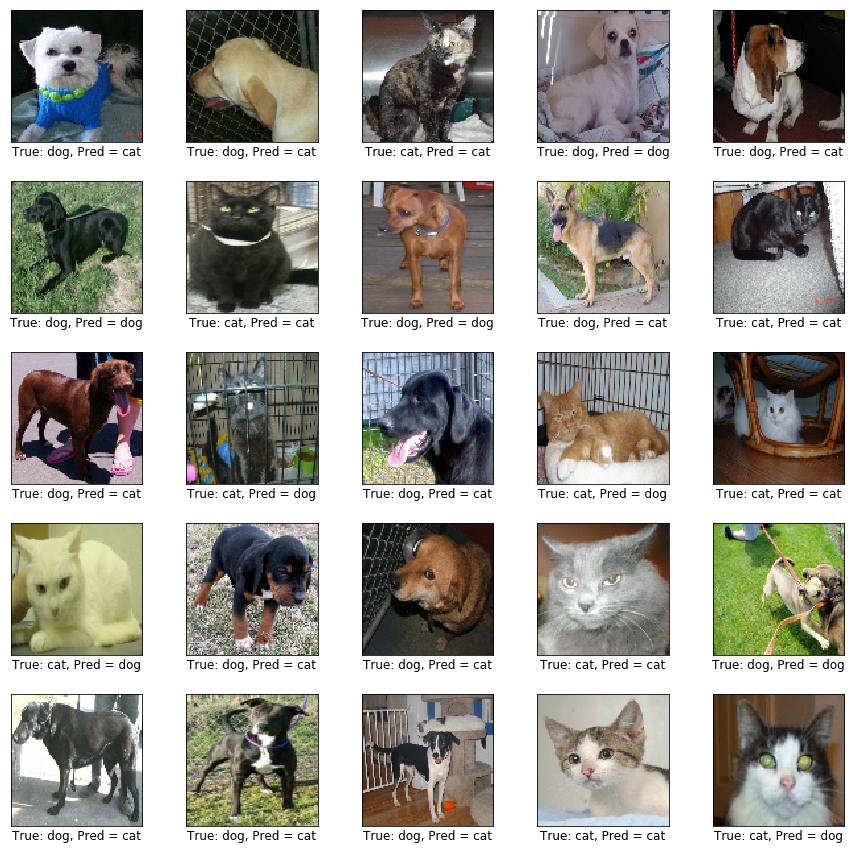

In [50]:
#get 25 images to plot
images = x_val[:25]
cls_true = label_val[:25]
cls_pred = decoded_label[:25]
plot_images(images, cls_true, cls_pred)